In [1]:
import torch
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import numpy as np


In [2]:
DEVICE = torch.device('cuda') # cuda
shuffle=False
batch_size = 64

In [3]:
# Loading dataset

loader = METRLADatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
train_dataset, val_dataset = temporal_signal_split(train_dataset, train_ratio=0.8)

In [4]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [5]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm

In [6]:
print("Cuda Available?: ", torch.cuda.is_available())
print("Current Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))

Cuda Available?:  True
Current Device:  NVIDIA GeForce GTX 1060 with Max-Q Design


In [7]:
# for batches
#https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/examples/recurrent/a3tgcn2_example.py
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=False, drop_last=True)

val_input = np.array(val_dataset.features) # (27399, 207, 2, 12)
val_target = np.array(val_dataset.targets) # (27399, 207, 12)
val_x_tensor = torch.from_numpy(val_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
val_dataset_new = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False,drop_last=True)

test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
print(test_x_tensor.shape)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
print(test_target_tensor.shape)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
#test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False, drop_last=True)

torch.Size([6850, 207, 2, 12])
torch.Size([6850, 207, 12])


In [8]:
#https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/examples/recurrent/dcrnn_example.py
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_size):
        super(RecurrentGCN, self).__init__()
        #self.embedding = nn.Embedding(node_features, hidden_size)
        self.encode1 = DCRNN(node_features, hidden_size, 3)
        self.encode2 = DCRNN(hidden_size, hidden_size, 3)
        self.decode1 = DCRNN(node_features, hidden_size, 3)
        self.decode2 = DCRNN(hidden_size, hidden_size, 3)
        #self.dropout = torch.nn.Dropout(0.33)
        self.linear = torch.nn.Linear(hidden_size, node_features)

    # x needs to be 207 x 12
    def forward(self, x, edge_index, edge_weight):
        # x is B, N, F, T
        x = x.permute(0,1,3,2)
        # x is B, N, T, F
        #print('x_in shape: ', x_in.shape)
        # get just speed
        x = x[:,:,:,0]
        #reshape to (B*N, T)
        x = x.reshape((x.shape[0]*x.shape[1], x.shape[2]))
        #x = self.embedding(x)
        #x = F.relu(x)
        h_enc1 = self.encode1(x, edge_index, edge_weight)
        h = F.relu(h_enc1)
        h_enc2 = self.encode2(h, edge_index, edge_weight)
        h = self.decode1(x, edge_index, edge_weight, h_enc1)
        h = F.relu(h)
        h = self.decode2(h, edge_index, edge_weight, h_enc2)
        h = self.linear(h)
        return h

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

model = RecurrentGCN(node_features = 12, hidden_size=64)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay_ratio=0.1

#steps = [20,30,40,50,60,70,80,90]
steps = [20, 30, 40]

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=steps, gamma=lr_decay_ratio)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=lr_decay_ratio)

loss_fn = torch.nn.MSELoss()
loss_fn2 = F.l1_loss

In [9]:
# Loading the graph once because it's a static graph
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    static_edge_attr = snapshot.edge_attr.to(DEVICE)
    break

# Training the model 
model.train()

epoch_vals = []
epoch_trains = []
for epoch in range(50):
    step = 0
    loss_list = []
    val_loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)         # Get model predictions
        # reshape back to BxNxT
        y_hat = y_hat.reshape((labels.shape))
        mean = [53.59967, 0.4982691]
        std = [20.209862, 0.28815305]
        labels = labels*std[0] + mean[0]
        y_hat = y_hat*std[0] + mean[0]
        loss = loss_fn2(y_hat, labels) 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        #loss = torch.sqrt(loss)
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("    train MAE: ", sum(loss_list)/len(loss_list))
    lr_scheduler.step()
    train_MAE = sum(loss_list)/len(loss_list)
    epoch_trains.append(train_MAE)
    print("Epoch {} train MAE: {:.4f}".format(epoch, train_MAE))

    model.eval()
    with torch.no_grad():
        for encoder_inputs, labels in val_loader:
            y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)         # Get model predictions
            # reshape back to BxNxT
            y_hat = y_hat.reshape((labels.shape))
            mean = [53.59967, 0.4982691]
            std = [20.209862, 0.28815305]
            labels = labels*std[0] + mean[0]
            y_hat = y_hat*std[0] + mean[0]
            loss = loss_fn2(y_hat, labels) 
            val_loss_list.append(loss.item())
            #if step % 100 == 0 :
            #    print("    train MAE: ", sum(loss_list)/len(loss_list))
    val_MAE = sum(val_loss_list)/len(val_loss_list)
    epoch_vals.append(val_MAE)
    print("Epoch {} val MAE: {:.4f}".format(epoch, val_MAE))
  




    train MAE:  7.114241555929184
    train MAE:  6.530715637207031
    train MAE:  6.140965917110443
Epoch 0 train MAE: 5.9624
Epoch 0 val MAE: 4.9091
    train MAE:  5.4642240178585055
    train MAE:  5.5137997013330455
    train MAE:  5.406397371689478
Epoch 1 train MAE: 5.3090
Epoch 1 val MAE: 4.7782
    train MAE:  5.2835443449020385
    train MAE:  5.2339547038078305
    train MAE:  5.204631634553274
Epoch 2 train MAE: 5.1236
Epoch 2 val MAE: 4.6569
    train MAE:  5.2024850499629975
    train MAE:  5.002234309911728
    train MAE:  5.0158179759979244
Epoch 3 train MAE: 4.9527
Epoch 3 val MAE: 4.5778
    train MAE:  5.07604553937912
    train MAE:  4.819027642309666
    train MAE:  4.865720772147179
Epoch 4 train MAE: 4.8169
Epoch 4 val MAE: 4.5355
    train MAE:  5.020811201333999
    train MAE:  4.759675938487053
    train MAE:  4.799415322542191
Epoch 5 train MAE: 4.7563
Epoch 5 val MAE: 4.5060
    train MAE:  4.9999297612905504
    train MAE:  4.768489034473896
    train MAE:

In [10]:
torch.save(model, "dcrnn_4_24_simple_fixed2")

In [11]:
print(epoch_vals)
print(epoch_trains)

[4.909137666926664, 4.778209031329435, 4.65690703532275, 4.577776387158562, 4.535453117594999, 4.506011474483153, 4.491671697532429, 4.476722265166395, 4.4740486639387465, 4.465169457477682, 4.459347906708717, 4.453027767644209, 4.450671090974527, 4.445255287955789, 4.448683023978682, 4.4551807564847605, 4.4715819590231956, 4.444668166076435, 4.497139688099132, 4.4570761904996985, 4.418982118192841, 4.416496109787156, 4.4138279138242495, 4.412678121643908, 4.41242010137614, 4.41132549564628, 4.411130263787858, 4.412038290675949, 4.4102748546530215, 4.409678035360925, 4.405436330113341, 4.404759348337264, 4.404867397292572, 4.405062334239483, 4.405045398456209, 4.404556297861478, 4.404918399759952, 4.404075769554166, 4.403934412822127, 4.404285833371036, 4.403417124314343, 4.4033461827565645, 4.403347278517836, 4.403362417462118, 4.403303392121897, 4.403311917536399, 4.40332163449596, 4.403330476494396, 4.403277136801797, 4.403323050873245]
[5.962447669073852, 5.308976337575076, 5.12362

In [12]:
#%pip install matplotlib
import matplotlib.pyplot as plt

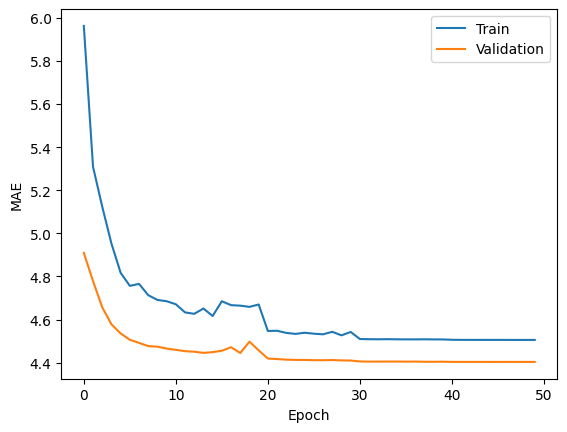

In [13]:
plt.plot(epoch_trains, label = 'Train')
plt.plot(epoch_vals, label = 'Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.show()



In [18]:
#torch.cuda.empty_cache()

In [14]:
model.eval()
step = 0
# Store for analysis
total_loss = []
predictions = []
labels_list = []
with torch.no_grad():
    for encoder_inputs, labels in test_loader:
        # Get model predictions
        y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)
        # reshape back to BxNxT
        y_hat = y_hat.reshape((labels.shape))
        # undo z-score
        #print(labels.shape)
        #print(y_hat.shape)
        mean = [53.59967, 0.4982691]
        std = [20.209862, 0.28815305]
        labels = labels*std[0] + mean[0]
        y_hat = y_hat*std[0] + mean[0]
        # Mean squared error
        #loss = loss_fn(y_hat, labels)
        # Mean absolute error
        loss = loss_fn2(y_hat, labels)
        total_loss.append(loss.item())
        # Store for analysis below
        predictions.append(y_hat.cpu())
        labels_list.append(labels.cpu())
    

print("Test MAE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MAE: 5.0973


In [15]:
predictions = torch.cat(predictions)
labels_list = torch.cat(labels_list)
pred = predictions.numpy()
lab = labels_list.numpy()
print(pred.shape)
print(lab.shape)

(6848, 207, 12)
(6848, 207, 12)


[23.499584 24.250172 24.861532 24.807306 25.09858  25.201572 25.40324
 26.050852 26.45882  26.542522 27.257511 27.722544]
[25.750002 21.857143 27.88889  29.125    41.375    60.625    52.333332
 34.75     27.125    27.750002 27.5      31.25    ]


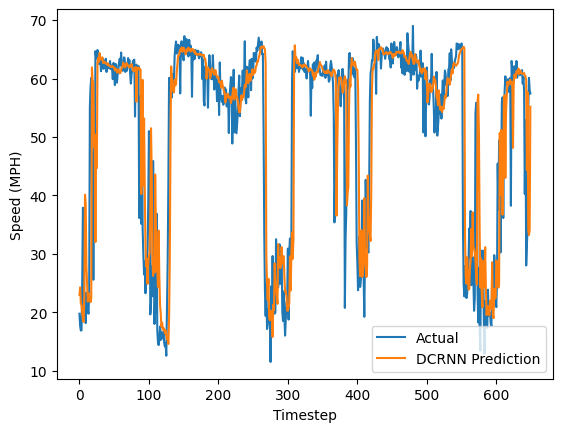

In [21]:
print(pred[2360, 130, :])
print(lab[2360, 130, :])
plt.plot(lab[2350:3000, 100, 2], label = 'Actual')
plt.plot(pred[2350:3000, 100, 2], label = 'DCRNN Prediction')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Speed (MPH)")
plt.show()

In [20]:
np.save('Results/DCRNN/pred.npy', pred)
np.save('Results/DCRNN/labels.npy', lab)